## Classification of galaxy morphology

### Problem description

The formation history of galaxies is not fully understood. There are many open questions: why do some galaxies have complex spiral arm structures while others are nearly featureless ellipsoids? What dynamical processes give rise to these structures? Why do star formation rates vary so much between galaxies?

In this problem, we will be taking a large set of real SDSS observations and training a neural network to classify the galaxies by their morphology while looking for outliers.
 
### What is the main issue?

Catalogs of extragalactic objects are growing rapidly, and with them, the amount of data we have as astronomers to sift through. One of the most basic, and most important, analysis tools is the classification of these objects. 

### What is the potential solution to this problem?

We can start by using a simple convolutional neural network to classify morphological images.

### What data will be used?

17,736 256x256 images from the [DESI Legacy Imaging Survey](https://www.legacysurvey.org/).

### Milestone estimators

- A **convolutional neural network** may be a good first step. You will need to decide on an appropriate metric to characterize its performance.
- **Pay attention to the data.** For example: how many examples are there for each morphology category? If the number differs between categories, what will you do about that? What about data augmentation or preprocessing?
- How could you detect **anomalies** in the dataset that don't fit well into any of the given categories?
- **Do you think the categories provided are a good way to classify morphology?** Can you come up with a different categorization direct from data using unsupervised learning?
- What other interesting tasks can you do with this dataset?

### Useful references:

- [Galaxy Zoo DECaLS: Detailed Visual Morphology Measurements from Volunteers and Deep Learning for 314,000 Galaxies](https://arxiv.org/abs/2102.08414)
- [GaMPEN: A Machine Learning Framework for Estimating Bayesian Posteriors of Galaxy Morphological Parameters](https://arxiv.org/abs/2207.05107)
- [Machine and Deep Learning Applied to Galaxy Morphology -- A Comparative Study](https://arxiv.org/abs/1901.07047)
- [Galaxy morphological classification in deep-wide surveys via unsupervised machine learning](https://arxiv.org/abs/1909.10537)
- [Galaxy morphology classification using automated machine learning](https://www.sciencedirect.com/science/article/abs/pii/S2213133721000469)
- [Machine Learning for Galaxy Morphology Classification](https://ui.adsabs.harvard.edu/abs/2010arXiv1005.0390G/abstract)
- [Machine learning technique for morphological classification of galaxies from the SDSS](https://www.aanda.org/articles/aa/full_html/2021/04/aa38981-20/aa38981-20.html)

## Setup

Creates a PyTorch dataset class to wrap the DECALs dataset. We use the version preprocessed by [astroNN](https://astronn.readthedocs.io/en/latest/index.html). The plot shows an example from the dataset. Note the colors are not the true observed colors -- the telescope uses the [g, r and z bands](https://en.wikipedia.org/wiki/Photometric_system).

In [31]:
from typing import Dict

from google.colab import drive
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import trange


drive.mount('/content/drive')
DATASET_PATH = "drive/MyDrive/Astromatic2022-Data/Problems/Galaxy10_DECals.h5"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
# class DECALSDataset(Dataset):
#     """
#     A simple pytorch HDF5 dataset.
#     """
#     def __init__(self, path: str = DATASET_PATH):
#         self.path = path
#         self.file = h5py.File(path, "r")
#         self.data_key = "images"
#         self.morphology_names = {
#             0: "Disturbed Galaxies",
#             1: "Merging Galaxies",
#             2: "Round Smooth Galaxies",
#             3: "In-between Round Smooth Galaxies",
#             4: "Cigar Shaped Smooth Galaxies",
#             5: "Barred Spiral Galaxies",
#             6: "Unbarred Tight Spiral Galaxies",
#             7: "Unbarred Loose Spiral Galaxies",
#             8: "Edge-on Galaxies without Bulge",
#             9: "Edge-on Galaxies with Bulge"
#         }
#         self.num_morphologies = len(self.morphology_names)

#     def __getitem__(self, index) -> Dict[str, torch.Tensor]:
#         # Move channel from first to last axis
#         data = torch.tensor(
#             self.file[self.data_key][index], dtype=torch.float32
#         ).moveaxis(2, 0)
#         redshift = torch.tensor(self.file["redshift"][index], dtype=torch.float32)
#         morphology = torch.tensor(self.file["ans"][index], dtype=int)
#         return {"data": data, "redshift": redshift, "morphology": morphology}
    
#     def __len__(self) -> int:
#         return len(self.file[self.data_key])


class DECALSDataLoader:
    """
    pyTorch Dataset for loading corrupt images and PSFs and their associated original images.
    """
    def __init__(self, path: str = DATASET_PATH):
        self.npix = 256
        self.file = h5py.File(path, mode="r")
        self._len = len(self.file["images"])
        self.morphology_names = {
            0: "Disturbed Galaxies",
            1: "Merging Galaxies",
            2: "Round Smooth Galaxies",
            3: "In-between Round Smooth Galaxies",
            4: "Cigar Shaped Smooth Galaxies",
            5: "Barred Spiral Galaxies",
            6: "Unbarred Tight Spiral Galaxies",
            7: "Unbarred Loose Spiral Galaxies",
            8: "Edge-on Galaxies without Bulge",
            9: "Edge-on Galaxies with Bulge"
        }

    def __len__(self):
        return self._len

    def getbatch(self, batched_ids):
        """
        get batch of examples in a same file from dataset
        """
        data_arr = self.file["images"][batched_ids]
        morphology_arr = self.file["ans"][batched_ids]
        redshift_arr = self.file["redshift"][batched_ids]

        data_tensor = torch.tensor(data_arr)
        data_tensor = data_tensor.moveaxis(-1, -3)
        data_tensor = data_tensor.reshape(-1, 3, self.npix, self.npix)
        morphology_tensor = torch.tensor(morphology_arr).reshape(-1, 1)
        redshift_tensor = torch.tensor(redshift_arr).reshape(-1, 1)

        return {"data": data_tensor.float(), "morphology": morphology_tensor.float(), "redshift": redshift_tensor.float()}

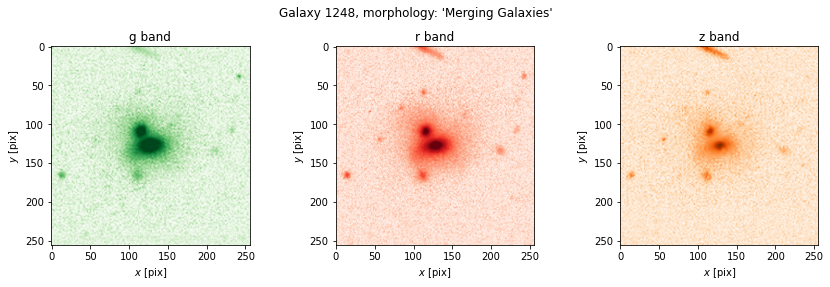

In [75]:
# Plot an image from the dataset
dl = DECALSDataLoader()
idx = 1248
sample = dl.getbatch([idx])
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

ax = axs[0]
ax.imshow(sample["data"][0, 0], cmap="Greens")
ax.set_title("g band")
ax.set_xlabel(r"$x$ [pix]")
ax.set_ylabel(r"$y$ [pix]")

ax = axs[1]
ax.imshow(sample["data"][0, 1], cmap="Reds")
ax.set_title("r band")
ax.set_xlabel(r"$x$ [pix]")
ax.set_ylabel(r"$y$ [pix]")

ax = axs[2]
ax.imshow(sample["data"][0, 2], cmap="Oranges")
ax.set_title("z band")
ax.set_xlabel(r"$x$ [pix]")
ax.set_ylabel(r"$y$ [pix]")

fig.suptitle(
    f"Galaxy {idx}, morphology: '{dataset.morphology_names[sample['morphology'].item()]}'"
)
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

## Inference

In [77]:
# TODO: define network
class Network(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, obs):
        ...

In [ ]:
network = Network()
network.to(DEVICE)

n_epochs = 2

for epoch in trange(n_epochs):
    network.train()
    # Loop over batches of training data
    for b in range(0, n_train, batch_size):
        # Get batch
        idxs = list(range(b, b + batch_size))
        batch = dl.getbatch(idxs)
        data = batch["data"].to(DEVICE)
        morphology = batch["morphology"].to(DEVICE)
        print(b)

    # Loop over batches of validation data
    network.eval()
    with torch.no_grad():
        for b in range(n_train, n_train + n_val, batch_size):
            idxs = list(range(b, b + batch_size))
            batch = dl.getbatch(idxs)
            data = batch["data"].to(DEVICE)
            morphology = batch["morphology"].to(DEVICE)

  0%|          | 0/2 [00:00<?, ?it/s]

0
64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3200
3264
3328
3392
3456
3520
3584
3648
3712
3776
3840
3904
3968
4032
4096
4160
4224
4288
4352
4416
4480
4544
4608
4672
4736
4800
4864
4928
4992
5056
5120
5184
5248
5312
5376
5440
5504
5568
5632
5696
5760
5824
5888
5952
6016
6080
6144
6208
6272
6336
6400
6464
6528
6592
6656
6720
6784
6848
6912
6976
7040
7104
7168
7232
7296
7360
7424
7488
7552
7616
7680
7744
7808
7872
7936
8000
8064
8128
8192
8256
8320
8384
8448
8512
8576
8640
8704
8768
8832
8896
8960
9024
9088
9152
9216
9280
9344
9408
9472
9536
9600
9664
9728
9792
9856
9920
9984
10048
10112
10176
10240
10304
10368
10432
10496
10560
10624
10688
10752
10816
10880
10944
11008
11072
11136
11200
11264
11328
11392
11456
11520
11584
11648
11712
11776
11840
11904
11968
12032
12096
12160
12224
12288
12352
12416
12480


In [79]:
# Initialize dataloader
dl = DECALSDataLoader()
# Feel free to change all the numbers below
batch_size = 64
n_tot = len(dl)
n_train = int(0.8 * n_tot)
n_val = int(0.1 * n_tot)
n_test = n_tot - n_train - n_val
# idxs_train = 
# idxs_val = ...
# idxs_test = ...

# # Initialize network
# network = Network()
# network.to(DEVICE)  # put network on GPU

# # Training loop
# n_epochs = 1
# for epoch in trange(n_epochs):  # progress bar
#     # TODO: train
#     network.train()
#     pass

#     # TODO: validate
#     network.eval()
#     with torch.no_grad():
#         pass

#     break